# Crime Analyzer — Classification — Hyperparameter Tuning and Training

Purpose
- Tune shortlisted models and select the best configuration for production.
- Optimize decision threshold (where applicable) to match business objectives (e.g., F1 for binary risk).

Inputs
- Train data: `JupyterOutputs/Classification (Preprocessing)/X_train.pkl` (labels will be engineered per fold).
- Modeling outputs: `JupyterOutputs/Classification (Modeling)/model_selection_results.csv` and `precomputed_targets.pkl`.

Outputs
- Best params per model: `JupyterOutputs/Classification (Tuning)/*_best_params.json`.
- Full search traces: `JupyterOutputs/Classification (Tuning)/*_manual_tuning_results.json`, `all_tuning_results.csv`.
- Best model info: `JupyterOutputs/Classification (Tuning)/best_model_info.json` and `<Model>_optimal_threshold.json`.

Key design decisions
- Search strategy: randomized/grid via ParameterSampler; sliding‑window CV consistent with Modeling.
- Objective: maximize F1 (binary) with PR‑AUC as tie‑breaker.
- Thresholding: sweep thresholds using true OOF predictions; never on the test set.
- Reproducibility: fixed `random_state`; persist full search space and results.

## Setup and Initialization

This section handles the initial setup, imports, and loading of artifacts from previous phases.

### Import Libraries

Import all necessary libraries for advanced tuning, model interpretation, and final training.

In [ ]:
import pandas as pd
import numpy as np
import os
import sys
import warnings
import joblib
import json
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime
from typing import Dict, Any, List, Tuple, Optional
import pickle
from scipy.stats import wilcoxon

from sklearn.base import BaseEstimator
from sklearn.model_selection import (
    StratifiedKFold, cross_validate, TimeSeriesSplit,
    validation_curve, learning_curve, RandomizedSearchCV, ParameterSampler
)
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    make_scorer, f1_score, accuracy_score, precision_score, recall_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve,
    average_precision_score, precision_recall_curve, matthews_corrcoef,
    classification_report, log_loss
)
from sklearn.base import clone

import shap
from sklearn.inspection import permutation_importance

from imblearn.ensemble import (
    EasyEnsembleClassifier, BalancedRandomForestClassifier, BalancedBaggingClassifier
)

from Utilities.custom_transformers import STKDEAndRiskLabelTransformer, cyclical_transform, CyclicalTransformer, TargetEngineeringPipeline

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import (
    RandomForestClassifier, ExtraTreesClassifier, 
    BaggingClassifier, AdaBoostClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline as ImbPipeline

# Set random seeds and display settings
np.random.seed(42)
warnings.filterwarnings('ignore', category=FutureWarning)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

print("All libraries imported successfully")

All libraries imported successfully


### Define Paths and Directories

Set up directory structure for loading previous results and saving final outputs.

In [2]:
# Define base directories
base_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "JupyterOutputs"))
preprocessing_dir = os.path.join(base_dir, "Classification (Preprocessing)")
modeling_dir = os.path.join(base_dir, "Classification (Modeling)")
final_results_dir = os.path.join(base_dir, "Classification (Tuning)")

# Create final results directory
os.makedirs(final_results_dir, exist_ok=True)

print(f"Directory Structure:")
print(f"   Preprocessing artifacts: {preprocessing_dir}")
print(f"   Modeling results: {modeling_dir}")
print(f"   Final outputs: {final_results_dir}")

# Verify required directories exist
required_dirs = [preprocessing_dir, modeling_dir]
missing_dirs = [d for d in required_dirs if not os.path.exists(d)]

if missing_dirs:
    print(f"Missing required directories: {missing_dirs}")
    raise FileNotFoundError(f"Required directories not found: {missing_dirs}")
else:
    print("All required directories found")

Directory Structure:
   Preprocessing artifacts: c:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Preprocessing)
   Modeling results: c:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Modeling)
   Final outputs: c:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Tuning)
All required directories found


### Load Previous Phase Artifacts

Load data, models, and results from previous phases to continue with advanced tuning.

In [3]:
print("=== Loading data and pipelines ===")

def load_preprocessing_artifacts(preprocessing_dir: str, modeling_dir: str) -> Dict[str, Any]:
    """Load preprocessing artifacts with comprehensive error handling.
    """
    print("=== Loading Preprocessing Artifacts ===")
    if not os.path.exists(preprocessing_dir):
        raise FileNotFoundError(f"Preprocessing directory not found: {preprocessing_dir}")

    try:
        # Load data arrays
        X_train = pd.read_pickle(os.path.join(preprocessing_dir, 'X_train.pkl'))
        X_test = pd.read_pickle(os.path.join(preprocessing_dir, 'X_test.pkl'))
    except FileNotFoundError as e:
        raise FileNotFoundError(f"Required data files missing: {e}")
    except Exception as e:
        raise RuntimeError(f"Error loading data files: {e}")

    # Load preprocessors if available
    preprocessor_general_ct = None
    preprocessor_trees_ct = None
    feature_selector_general = None
    feature_selector_trees = None
    
    general_path = os.path.join(preprocessing_dir, 'preprocessing_pipeline_general.joblib')
    trees_path = os.path.join(preprocessing_dir, 'preprocessing_pipeline_trees.joblib')
    
    if os.path.exists(general_path):
        try:
            pipeline_general = joblib.load(general_path)
            preprocessor_general_ct = pipeline_general.named_steps['preprocessor']
            feature_selector_general = pipeline_general.named_steps['feature_selection']
        except Exception as e:
            warnings.warn(f"Failed to load general preprocessor: {e}")
    else:
        preprocessor_general_ct = None

    if os.path.exists(trees_path):
        try:
            pipeline_trees = joblib.load(trees_path)
            preprocessor_trees_ct = pipeline_trees.named_steps['preprocessor']
            feature_selector_trees = pipeline_trees.named_steps['feature_selection']
        except Exception as e:
            warnings.warn(f"Failed to load trees preprocessor: {e}")
    else:
        preprocessor_trees_ct = None

    # Load STKDE parameters if available
    hs_optimal, ht_optimal = 200.0, 60.0
    stkde_path = os.path.join(preprocessing_dir, 'stkde_optimal_params.json')
    if os.path.exists(stkde_path):
        try:
            with open(stkde_path, 'r') as f:
                params = json.load(f)
            hs_optimal = params.get('hs_opt', hs_optimal)
            ht_optimal = params.get('ht_opt', ht_optimal)
        except Exception as e:
            warnings.warn(f"Failed to load STKDE parameters: {e}")

    precomputed_targets = None
    precomputed_targets_path = os.path.join(modeling_dir, 'precomputed_targets.pkl')
    if os.path.exists(precomputed_targets_path):
        print(f"=== Loading Precomputed Targets ===")
        try:
            with open(precomputed_targets_path, 'rb') as f:
                precomputed_targets = pickle.load(f)
            print("Loaded precomputed targets from disk.")
        except Exception as e:
            warnings.warn(f"Failed to load precomputed targets: {e}")
    else:
        print("No precomputed targets found.")

    model_selection_results = None
    model_selection_results_path = os.path.join(modeling_dir, 'model_selection_results.csv')
    if os.path.exists(model_selection_results_path):
        print(f"=== Loading Model Selection Results ===")
        try:
            model_selection_results = pd.read_csv(model_selection_results_path)
            print("Loaded model selection results from disk.")
        except Exception as e:
            warnings.warn(f"Failed to load model selection results: {e}")
    else:
        print("No model selection results found.")

    models_to_tune = [
        'LogisticRegression', 'XGBoost',
        'SVC_linear', 'BalancedBagging',
        'LightGBM', 'RandomForest'
    ]

    tree_models = [
        'RandomForest', 'XGBoost', 'LightGBM', 'BalancedBagging'
    ]

    general_models = [
        'LogisticRegression', 'SVC_linear'
    ]

    categorization = {
        'tree_preprocessing': tree_models,
        'general_preprocessing': general_models
    }

    return {
        'X_train': X_train,
        'X_test': X_test,
        'feature_names': list(X_train.columns),
        'hs_optimal': hs_optimal,
        'ht_optimal': ht_optimal,
        'preprocessor_general_ct': preprocessor_general_ct,
        'feature_selector_general': feature_selector_general,
        'preprocessor_trees_ct': preprocessor_trees_ct,
        'feature_selector_trees': feature_selector_trees,
        'precomputed_targets': precomputed_targets,
        'model_selection_results': model_selection_results,
        'models_to_tune': models_to_tune,
        'categorization': categorization
    }
    
# Load and validate data
try:
    artifacts = load_preprocessing_artifacts(preprocessing_dir, modeling_dir)
    X_train = artifacts['X_train']
    X_test = artifacts['X_test']
    feature_names = artifacts['feature_names']
    hs_optimal = artifacts['hs_optimal']
    ht_optimal = artifacts['ht_optimal']
    preprocessor_general_ct = artifacts['preprocessor_general_ct']
    feature_selector_general = artifacts['feature_selector_general']
    preprocessor_trees_ct = artifacts['preprocessor_trees_ct']
    feature_selector_trees = artifacts['feature_selector_trees']
    precomputed_targets = artifacts['precomputed_targets']
    model_selection_results = artifacts['model_selection_results']
    models_to_tune = artifacts['models_to_tune']
    categorization = artifacts['categorization']

    print(f"\nX_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
    print(f"Feature names: {', '.join(feature_names)}")
    print(f"hs_optimal: {hs_optimal}, ht_optimal: {ht_optimal}")
    print(f"Precomputed targets: {precomputed_targets is not None}")
    print(f"Model selection results: {model_selection_results is not None}")
    print(f"Models to tune: {', '.join(models_to_tune)}")
    print(f"Categorization: {categorization}")

except Exception as e:
    print(f"Failed to load preprocessing artifacts: {e}")
    raise

train_df = X_train.copy()
if all(col in train_df.columns for col in ['YEAR', 'MONTH', 'DAY', 'HOUR']):
    X_train_sorted = train_df.sort_values(by=['YEAR', 'MONTH', 'DAY', 'HOUR'])
    print("X_train sorted chronologically for CV.")
else:
    X_train_sorted = X_train 
    warnings.warn("Time columns not found in X_train, using original order. This might affect TimeSeriesSplit.")


=== Loading data and pipelines ===
=== Loading Preprocessing Artifacts ===
=== Loading Precomputed Targets ===
Loaded precomputed targets from disk.
=== Loading Model Selection Results ===
Loaded model selection results from disk.

X_train shape: (570076, 33), X_test shape: (144344, 33)
Feature names: BORO_NM, LOC_OF_OCCUR_DESC, VIC_AGE_GROUP, VIC_RACE, VIC_SEX, Latitude, Longitude, BAR_DISTANCE, NIGHTCLUB_DISTANCE, ATM_DISTANCE, ATMS_COUNT, BARS_COUNT, BUS_STOPS_COUNT, METROS_COUNT, NIGHTCLUBS_COUNT, SCHOOLS_COUNT, METRO_DISTANCE, MIN_POI_DISTANCE, AVG_POI_DISTANCE, MAX_POI_DISTANCE, TOTAL_POI_COUNT, POI_DIVERSITY, POI_DENSITY_SCORE, HOUR, DAY, WEEKDAY, IS_WEEKEND, MONTH, YEAR, SEASON, TIME_BUCKET, IS_HOLIDAY, IS_PAYDAY
hs_optimal: 250, ht_optimal: 75
Precomputed targets: True
Model selection results: True
Models to tune: LogisticRegression, XGBoost, SVC_linear, BalancedBagging, LightGBM, RandomForest
Categorization: {'tree_preprocessing': ['RandomForest', 'XGBoost', 'LightGBM', 'Bala

## Model Selection and Hyperparameter Tuning

Based on the cross-validation results, we select the best performing model and perform hyperparameter tuning to optimize its performance. The tuning process uses the same leakage-free approach with proper target engineering within each fold.

In [4]:
def manual_cv_hyperparameter_tuning(
    model_name: str,
    model_instance: BaseEstimator,
    param_grid: Dict[str, Any],
    model_categories: Dict[str, List[str]],
    preprocessor_trees_ct: Any,
    preprocessor_general_ct: Any,
    feature_selector_general: Any,
    feature_selector_trees: Any,
    precomputed_targets: Dict[int, Dict[str, Any]],
    X_train_sorted: pd.DataFrame,
    N_SPLITS_CV: int = 5,
    n_iter: int = 20,
    random_state: int = 42,
    scoring: str = 'f1',
    results_dir: Optional[str] = None
) -> Tuple[Dict[str, Any], float, List[Dict[str, Any]]]:
    """
    Manual hyperparameter search with precomputed folds and targets.
    For each parameter combination, performs cross-validation using precomputed splits and engineered targets.
    Returns the best parameter set and all results.
    """
    np.random.seed(random_state)
    best_score = -np.inf
    best_params = None
    all_results = []

    # Select preprocessing pipeline
    if model_name in model_categories.get('tree_preprocessing', []):
        preprocessor_ct = preprocessor_trees_ct
        feature_selector = feature_selector_trees
    else:
        preprocessor_ct = preprocessor_general_ct
        feature_selector = feature_selector_general

    param_list = list(ParameterSampler(param_grid, n_iter=n_iter, random_state=random_state))

    for i, params in enumerate(param_list, 1):
        print(f"  Testing params {i}/{len(param_list)} for {model_name}")
        fold_scores = []
        for fold_idx in range(N_SPLITS_CV):
            # Get precomputed data for the fold
            train_idx = precomputed_targets[fold_idx]['train_idx']
            val_idx = precomputed_targets[fold_idx]['val_idx']
            y_tr_engineered = precomputed_targets[fold_idx]['y_train_engineered']
            y_val_engineered = precomputed_targets[fold_idx]['y_val_engineered']

            X_tr = X_train_sorted.iloc[train_idx]
            X_val = X_train_sorted.iloc[val_idx]

            y_tr_proc = np.array(y_tr_engineered).astype(int)
            y_val_proc = np.array(y_val_engineered).astype(int)

            # Build a complete pipeline including the classifier
            model = clone(model_instance)
            pipeline = ImbPipeline([
                ('preprocessor', clone(preprocessor_ct)),
                ('feature_selection', clone(feature_selector)),
                ('classifier', model)
            ])

            # Set the hyperparameters for the current iteration
            pipeline.set_params(**params)

            pipeline.fit(X_tr, y_tr_proc)
            y_pred = pipeline.predict(X_val)

            if scoring == 'f1':
                score = f1_score(y_val_proc, y_pred)
            elif scoring == 'roc_auc':
                if hasattr(pipeline, "predict_proba"):
                    y_score = pipeline.predict_proba(X_val)[:, 1]
                elif hasattr(pipeline, "decision_function"):
                    y_score = pipeline.decision_function(X_val)
                else:
                    y_score = y_pred
                score = roc_auc_score(y_val_proc, y_score)
            else:
                raise ValueError("Unsupported scoring metric")

            fold_scores.append(score)
            print(f"[DEBUG] Model: {model_name}, Params: {params}, Fold: {fold_idx+1}, F1: {score:.4f}")

        mean_score = np.mean(fold_scores)
        std_score = np.std(fold_scores)
        result = {
            'params': params,
            'mean_score': mean_score,
            'std_score': std_score,
            'fold_scores': fold_scores  # Save per-fold scores for Wilcoxon test
        }
        all_results.append(result)
        if mean_score > best_score:
            best_score = mean_score
            best_params = params
            best_result = result

    # Save results
    if results_dir:
        out_path = os.path.join(results_dir, f"{model_name}_manual_tuning_results.json")
        with open(out_path, "w") as f:
            json.dump({'best_params': best_params, 'best_score': best_score, 'all_results': all_results}, f, indent=2)
        print(f"Tuning results saved to: {out_path}")

    return best_params, best_score, all_results

def define_parameter_grids(general_models, tree_models, random_state=42):

    model_configs = {}
    for m in general_models:
        model_configs[m] = {'preprocessing_type': 'general'}
    for m in tree_models:
        model_configs[m] = {'preprocessing_type': 'tree'}

    param_grids = {}

    for model_name, cfg in model_configs.items():
        grid = {}

        # Classifier-specific parameters
        if model_name == 'LogisticRegression':
            grid.update({
                'classifier__C': [0.01, 0.1, 1.0, 10.0, 100.0],
                'classifier__penalty': ['l1', 'l2'],
                'classifier__solver': ['liblinear'],
            })
        elif model_name == 'XGBoost':
            grid.update({
                'classifier__n_estimators': [100, 200, 300],
                'classifier__max_depth': [3, 6, 8],
                'classifier__learning_rate': [0.05, 0.1],
                'classifier__subsample': [0.8, 1.0],
                'classifier__colsample_bytree': [0.8, 1.0],
            })
        elif model_name == 'SVC_linear':
            grid.update({
                'classifier__C': [0.01, 0.1, 1.0, 10.0],
                'classifier__dual': [False],
            })
        elif model_name == 'BalancedBagging':
            grid.update({
                'classifier__n_estimators': [50, 100, 200],
                'classifier__max_samples': [0.5, 0.7, 1.0],
                'classifier__max_features': [0.5, 1.0],
                'classifier__bootstrap': [True, False],
                'classifier__bootstrap_features': [False],
            })
        elif model_name == 'LightGBM':
            grid.update({
                'classifier__n_estimators': [100, 200],
                'classifier__max_depth': [3, 6, -1],
                'classifier__learning_rate': [0.05, 0.1],
                'classifier__min_child_samples': [20, 50],
                'classifier__num_leaves': [31, 63], 
                'classifier__subsample': [0.7, 1.0],
                'classifier__colsample_bytree': [0.7, 1.0],
            })
        elif model_name == 'RandomForest':
            grid.update({
                'classifier__n_estimators': [100, 200],
                'classifier__max_depth': [10, 15, None],
                'classifier__min_samples_split': [2, 5],
                'classifier__min_samples_leaf': [1, 2],
                'classifier__max_features': ['sqrt', None],
                'classifier__bootstrap': [True, False],
            })
            
        param_grids[model_name] = grid

    return param_grids

### Model Instances and Parameter Grids

Define the model instances and their respective hyperparameter grids for tuning.

In [5]:
model_instances = {
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced', n_jobs=-1, solver='liblinear'),
    'XGBoost': XGBClassifier(random_state=42, n_jobs=-1, eval_metric='logloss', max_depth=6, learning_rate=0.1, scale_pos_weight=None),
    'SVC_linear': LinearSVC(C=1.0, penalty='l2', loss='squared_hinge', max_iter=3000, class_weight='balanced', random_state=42),
    'BalancedBagging': BalancedBaggingClassifier(random_state=42, n_jobs=-1, sampling_strategy='auto'),
    'LightGBM': LGBMClassifier(random_state=42, n_jobs=-1, verbosity=-1, max_depth=10, learning_rate=0.1, is_unbalance=True),
    'RandomForest': RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1, max_depth=15),
}

# Define parameter grids for each model
param_grids = define_parameter_grids(
    categorization['general_preprocessing'],
    categorization['tree_preprocessing'],
    random_state=42
)

all_tuning_results = []

for idx, model_name in enumerate(models_to_tune, 1):
    print(f"\n=== Manual Hyperparameter Tuning for {model_name} ({idx}/{len(models_to_tune)}) ===")
    if model_name not in param_grids:
        print(f"  No parameter grid defined for {model_name}, skipping.")
        continue

    # Path to the tuning results file for this model
    results_file = os.path.join(final_results_dir, f"{model_name}_manual_tuning_results.json")
    if os.path.exists(results_file):
        # If results already exist, load them and skip tuning
        print(f"  Loading existing tuning results from {results_file}")
        with open(results_file, "r") as f:
            tuning_results = json.load(f)
        best_params = tuning_results['best_params']
        best_score = tuning_results['best_score']
        all_results = tuning_results['all_results']
        all_tuning_results.append({
            "model_name": model_name,
            "best_params": best_params,
            "best_score": best_score
        })
        continue
    else:
        model_instance = model_instances[model_name]

        try:
            # Perform manual cross-validated hyperparameter tuning
            best_params, best_score, all_results = manual_cv_hyperparameter_tuning(
                model_name=model_name,
                model_instance=model_instance,
                param_grid=param_grids[model_name],
                model_categories=categorization,
                preprocessor_trees_ct=preprocessor_trees_ct,
                preprocessor_general_ct=preprocessor_general_ct,
                feature_selector_general=feature_selector_general,
                feature_selector_trees=feature_selector_trees,
                precomputed_targets=precomputed_targets,
                X_train_sorted=X_train_sorted,
                N_SPLITS_CV=5,
                n_iter=20,
                random_state=42,
                scoring='f1',
                results_dir=final_results_dir
            )
            print(f"Best params: {best_params}")
            print(f"Best mean score: {best_score:.4f}")

            # Save the best params and full tuning results for this model
            with open(os.path.join(final_results_dir, f"{model_name}_best_params.json"), "w") as f:
                json.dump(best_params, f, indent=2)
            with open(os.path.join(final_results_dir, f"{model_name}_manual_tuning_results.json"), "w") as f:
                json.dump({'best_params': best_params, 'best_score': best_score, 'all_results': all_results}, f, indent=2)
            print(f"  Saved tuning results for {model_name}")

            all_tuning_results.append({
                "model_name": model_name,
                "best_params": best_params,
                "best_score": best_score
            })
        except Exception as e:
            print(f"  Error during tuning for {model_name}: {e}")
            all_tuning_results.append({
                "model_name": model_name,
                "error": str(e)
            })



=== Manual Hyperparameter Tuning for LogisticRegression (1/6) ===
  Loading existing tuning results from c:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Tuning)\LogisticRegression_manual_tuning_results.json

=== Manual Hyperparameter Tuning for XGBoost (2/6) ===
  Loading existing tuning results from c:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Tuning)\XGBoost_manual_tuning_results.json

=== Manual Hyperparameter Tuning for SVC_linear (3/6) ===
  Loading existing tuning results from c:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Tuning)\SVC_linear_manual_tuning_results.json

=== Manual Hyperparameter Tuning for BalancedBagging (4/6) ===
  Loading existing tuning results from c:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Tuning)\BalancedBagging_manual_tuning_results.json

=== Manual Hyperparameter Tuning for LightGBM (5/6) ===
  Loading existing tuning results f

## Select the Best Model After Hyperparameter Tuning

After hyperparameter optimization, we visualize the performance of all tuned models and select the best one based on the primary metric (e.g., F1 score). The following code block generates comparative plots and identifies the top-performing model for final evaluation and threshold optimization.


=== Creating Results Visualization ===


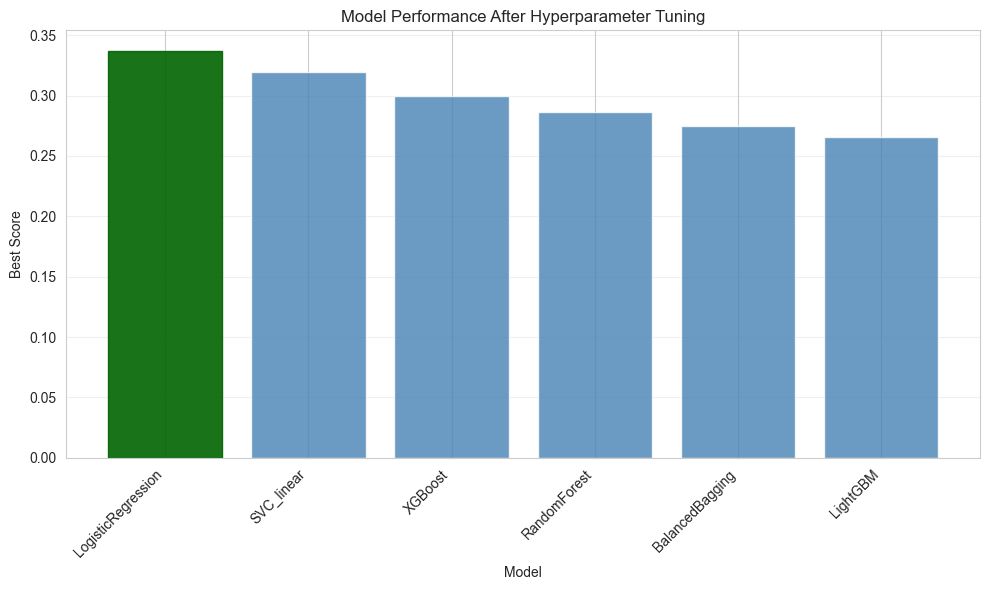


Best model after tuning: LogisticRegression (F1: 0.3371)


In [6]:
def create_results_visualization(results_df: pd.DataFrame, analysis: dict = None, primary_metric: str = 'f1_mean') -> None:
    """
    Visualize model selection results after hyperparameter tuning.
    """
    print("\n=== Creating Results Visualization ===")
    if results_df.empty:
        print("No results to visualize.")
        return

    # Sort by primary metric
    sorted_results = results_df.sort_values(primary_metric, ascending=False)
    plt.figure(figsize=(10, 6))
    bars = plt.bar(sorted_results['model_name'], sorted_results[primary_metric], color='steelblue', alpha=0.8)
    plt.xlabel('Model')
    plt.ylabel(primary_metric.replace('_', ' ').title())
    plt.title('Model Performance After Hyperparameter Tuning')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)

    # Highlight the best model
    if len(bars) > 0:
        bars[0].set_color('darkgreen')
        bars[0].set_alpha(0.9)

    plt.tight_layout()
    plt.show()

    # Print best model
    best_model_row = sorted_results.iloc[0]
    print(f"\nBest model after tuning: {best_model_row['model_name']} (F1: {best_model_row[primary_metric]:.4f})")

# Load tuning results from all_tuning_results or from saved files
tuning_results_path = os.path.join(final_results_dir, "all_tuning_results.csv")
if os.path.exists(tuning_results_path):
    tuning_results_df = pd.read_csv(tuning_results_path)
else:
    tuning_results_df = pd.DataFrame(all_tuning_results)
    tuning_results_df.to_csv(tuning_results_path, index=False)

# Visualize and select best model
create_results_visualization(tuning_results_df, primary_metric='best_score')
best_model_row = tuning_results_df.sort_values('best_score', ascending=False).iloc[0]
best_model_name = best_model_row['model_name']

### Statistical Comparison of Models

Extract per-fold scores for each model and perform Wilcoxon signed-rank tests to statistically compare model performances. We use a one-sided alternative ('greater'), i.e., testing whether model A tends to outperform model B across folds.

In [7]:
def extract_fold_scores_for_wilcoxon(tuning_results_df, final_results_dir):
    """
    Extract per-fold scores for each model from tuning results.
    """
    model_fold_scores = {}
    for _, row in tuning_results_df.iterrows():
        model_name = row['model_name']
        results_file = os.path.join(final_results_dir, f"{model_name}_manual_tuning_results.json")
        if os.path.exists(results_file):
            with open(results_file, "r") as f:
                results = json.load(f)
            best_params = results['best_params']
            # Find the result dict for best_params
            for res in results['all_results']:
                if res['params'] == best_params:
                    fold_scores = res.get('fold_scores', None)
                    if fold_scores is not None:
                        model_fold_scores[model_name] = fold_scores
                    break
    return model_fold_scores

# Load tuning results from all_tuning_results or from saved files
tuning_results_path = os.path.join(final_results_dir, "all_tuning_results.csv")
if os.path.exists(tuning_results_path):
    tuning_results_df = pd.read_csv(tuning_results_path)
else:
    tuning_results_df = pd.DataFrame(all_tuning_results)
    tuning_results_df.to_csv(tuning_results_path, index=False)

# Extract fold scores for Wilcoxon test
model_fold_scores = extract_fold_scores_for_wilcoxon(tuning_results_df, final_results_dir)

# Wilcoxon test between all pairs (one-sided: m1 > m2)
model_names = list(model_fold_scores.keys())
wilcoxon_results = {}

for i, m1 in enumerate(model_names):
    wilcoxon_results[m1] = []
    for j, m2 in enumerate(model_names):
        if i == j:
            continue
        try:
            # One-sided test: H1 is that m1's fold scores are greater than m2's
            stat, p = wilcoxon(model_fold_scores[m1], model_fold_scores[m2], alternative='greater')
            wilcoxon_results[m1].append({'vs': m2, 'p_value': p})
        except Exception as e:
            wilcoxon_results[m1].append({'vs': m2, 'error': str(e)})

# Select the model that is significantly better than all others (one-sided p < 0.05)
best_model_candidates = []
for m1, results in wilcoxon_results.items():
    is_better_count = 0
    for r in results:
        if 'p_value' in r and r['p_value'] < 0.05:
            m2 = r['vs']
            # Check if m1 actually has higher median scores than m2
            if np.median(model_fold_scores[m1]) > np.median(model_fold_scores[m2]):
                is_better_count += 1
    if is_better_count == len(model_names) - 1:
        best_model_candidates.append(m1)

if best_model_candidates:
    best_model_name = best_model_candidates[0]
    print(f"Best model selected by one-sided Wilcoxon (greater): {best_model_name}")
else:
    print("No model is significantly better than all others by one-sided Wilcoxon. Defaulting to highest mean score.")
    best_model_row = tuning_results_df.sort_values('best_score', ascending=False).iloc[0]
    best_model_name = best_model_row['model_name']

# Optionally print Wilcoxon results
print("Wilcoxon test results (one-sided: m1 > m2, p-values):")
for m, results in wilcoxon_results.items():
    formatted = []
    for r in results:
        if 'p_value' in r:
            formatted.append(f"{r['vs']} (p={r['p_value']:.4f})")
        else:
            formatted.append(f"{r['vs']} (error)")
    print(f"{m}: {formatted}")

No model is significantly better than all others by one-sided Wilcoxon. Defaulting to highest mean score.
Wilcoxon test results (one-sided: m1 > m2, p-values):
LogisticRegression: ['XGBoost (p=0.2188)', 'SVC_linear (p=0.0312)', 'BalancedBagging (p=0.0625)', 'LightGBM (p=0.0625)', 'RandomForest (p=0.0625)']
XGBoost: ['LogisticRegression (p=0.8438)', 'SVC_linear (p=0.7812)', 'BalancedBagging (p=0.0312)', 'LightGBM (p=0.0312)', 'RandomForest (p=0.0312)']
SVC_linear: ['LogisticRegression (p=1.0000)', 'XGBoost (p=0.3125)', 'BalancedBagging (p=0.0625)', 'LightGBM (p=0.0625)', 'RandomForest (p=0.2188)']
BalancedBagging: ['LogisticRegression (p=0.9688)', 'XGBoost (p=1.0000)', 'SVC_linear (p=0.9688)', 'LightGBM (p=0.0938)', 'RandomForest (p=1.0000)']
LightGBM: ['LogisticRegression (p=0.9688)', 'XGBoost (p=1.0000)', 'SVC_linear (p=0.9688)', 'BalancedBagging (p=0.9375)', 'RandomForest (p=1.0000)']
RandomForest: ['LogisticRegression (p=0.9688)', 'XGBoost (p=1.0000)', 'SVC_linear (p=0.8438)', 'Bala

# Threshold Optimization

## Introduction

This section optimizes the classification threshold for the best performing model to maximize F1 score.


Starting Threshold Optimization for LogisticRegression (using OOF CV folds)
--- Generating True Out-of-Fold (OOF) Predictions ---
  Processing Fold 1/5...


c:\Users\ferdi\anaconda3\envs\DMML\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


  Processing Fold 2/5...


c:\Users\ferdi\anaconda3\envs\DMML\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


  Processing Fold 3/5...


c:\Users\ferdi\anaconda3\envs\DMML\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


  Processing Fold 4/5...


c:\Users\ferdi\anaconda3\envs\DMML\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


  Processing Fold 5/5...


c:\Users\ferdi\anaconda3\envs\DMML\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


--- OOF Prediction Generation Complete ---

=== Threshold Optimization for LogisticRegression (using OOF CV folds) ===
Optimal threshold: 0.64 (F1: 0.4005)
Results saved to: c:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Tuning)\LogisticRegression_threshold_optimization.json
Optimal threshold: 0.64 (F1: 0.4005)
Results saved to: c:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Tuning)\LogisticRegression_threshold_optimization.json


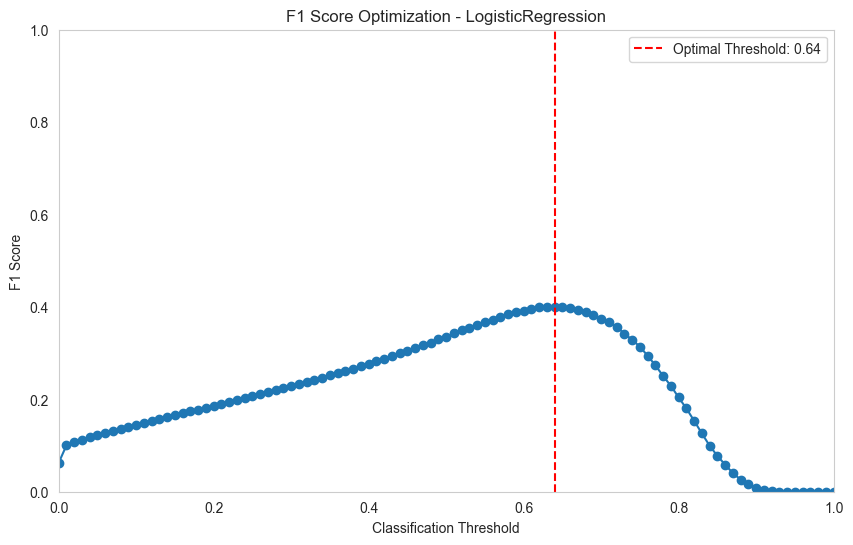

In [8]:
def optimize_classification_threshold_from_probs(y_probs: np.ndarray, y_true: np.ndarray,
                                                model_name: str, results_dir: str) -> Tuple[float, Dict[str, Any]]:
    """
    Optimize the classification threshold to maximize F1 score, given predicted probabilities and true labels.
    """
    print(f"\n=== Threshold Optimization for {model_name} (using OOF CV folds) ===")
    try:
        thresholds = np.arange(0.0, 1.01, 0.01)
        f1_scores = []
        for threshold in thresholds:
            y_pred = (y_probs >= threshold).astype(int)
            f1 = f1_score(y_true, y_pred)
            f1_scores.append(f1)

        max_f1_index = np.argmax(f1_scores)
        optimal_threshold = thresholds[max_f1_index]
        max_f1_score = f1_scores[max_f1_index]

        print(f"Optimal threshold: {optimal_threshold:.2f} (F1: {max_f1_score:.4f})")

        # Save results
        results_file = os.path.join(results_dir, f"{model_name}_threshold_optimization.json")
        with open(results_file, 'w') as f:
            json.dump({
                'optimal_threshold': float(optimal_threshold),
                'max_f1_score': float(max_f1_score),
                'thresholds': thresholds.tolist(),
                'f1_scores': f1_scores,
                'model_name': model_name,
                'timestamp': datetime.now().isoformat()
            }, f, indent=2)

        print(f"Results saved to: {results_file}")

        # Plot F1 scores by threshold
        plt.figure(figsize=(10, 6))
        plt.plot(thresholds, f1_scores, marker='o')
        plt.xlabel('Classification Threshold')
        plt.ylabel('F1 Score')
        plt.title(f'F1 Score Optimization - {model_name}')
        plt.grid()
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.axvline(optimal_threshold, color='r', linestyle='--', label=f'Optimal Threshold: {optimal_threshold:.2f}')
        plt.legend()
        plot_file = os.path.join(results_dir, f"{model_name}_f1_threshold_optimization.png")
        plt.savefig(plot_file, dpi=300, bbox_inches='tight')
        plt.show()

        return optimal_threshold, {
            'optimal_threshold': float(optimal_threshold),
            'max_f1_score': float(max_f1_score),
            'thresholds': thresholds.tolist(),
            'f1_scores': f1_scores
        }

    except Exception as e:
        print(f"Threshold optimization failed: {e}")
        return 0.5, {'error': str(e)}

def get_oof_predictions(
    best_params: Dict[str, Any],
    model_instance: BaseEstimator,
    X_train_sorted: pd.DataFrame,
    precomputed_targets: Dict[int, Dict[str, Any]],
    model_categories: Dict[str, List[str]],
    preprocessor_trees_ct: Any,
    preprocessor_general_ct: Any,
    feature_selector_general: Any,
    feature_selector_trees: Any,
    model_name: str
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generates true out-of-fold (OOF) predictions by retraining a model for each CV fold.
    This prevents data leakage during threshold optimization.
    """
    print("--- Generating True Out-of-Fold (OOF) Predictions ---")
    oof_probs = np.zeros(len(X_train_sorted))
    oof_targets = np.zeros(len(X_train_sorted))

    # Select the correct preprocessing components based on model type
    if model_name in model_categories.get('tree_preprocessing', []):
        preprocessor_ct = preprocessor_trees_ct
        feature_selector = feature_selector_trees
    else:
        preprocessor_ct = preprocessor_general_ct
        feature_selector = feature_selector_general

    for fold_idx in precomputed_targets:
        print(f"  Processing Fold {fold_idx+1}/{len(precomputed_targets)}...")
        train_idx = precomputed_targets[fold_idx]['train_idx']
        val_idx = precomputed_targets[fold_idx]['val_idx']
        y_tr_engineered = precomputed_targets[fold_idx]['y_train_engineered']
        y_val_engineered = precomputed_targets[fold_idx]['y_val_engineered']

        y_tr_proc = np.array(y_tr_engineered).astype(int)
        y_val_proc = np.array(y_val_engineered).astype(int)

        X_tr, X_val = X_train_sorted.iloc[train_idx], X_train_sorted.iloc[val_idx]

        # Build the full pipeline for this fold
        model = clone(model_instance)
        clf_params = {k.replace('classifier__', ''): v for k, v in best_params.items() if k.startswith('classifier__')}
        if clf_params:
            model.set_params(**clf_params)

        pipeline = ImbPipeline([
            ('preprocessor', clone(preprocessor_ct)),
            ('feature_selection', clone(feature_selector)),
            ('classifier', model)
        ])
        
        # Set preprocessing params if they were tuned
        prep_params = {k: v for k, v in best_params.items() if not k.startswith('classifier__')}
        if prep_params:
            pipeline.set_params(**prep_params)

        # Fit the pipeline on the training part of the fold
        pipeline.fit(X_tr, y_tr_proc)

        # Predict probabilities on the validation part of the fold
        classifier = pipeline.named_steps['classifier']
        if hasattr(classifier, "predict_proba"):
            y_probs = pipeline.predict_proba(X_val)[:, 1]
        elif hasattr(classifier, "decision_function"):
            decision = pipeline.decision_function(X_val)
            min_dec, max_dec = decision.min(), decision.max()
            y_probs = (decision - min_dec) / (max_dec - min_dec) if (max_dec - min_dec) > 1e-8 else np.full(len(X_val), 0.5)
        else:
            y_probs = np.full(len(X_val), 0.5)
        
        oof_probs[val_idx] = y_probs
        oof_targets[val_idx] = y_val_proc
        
    print("--- OOF Prediction Generation Complete ---")
    return oof_probs, oof_targets

# --- Use OOF predictions for threshold optimization ---
if best_model_name:
    print(f"\nStarting Threshold Optimization for {best_model_name} (using OOF CV folds)")
    
    # Load best parameters and model instance
    with open(os.path.join(final_results_dir, f"{best_model_name}_best_params.json"), "r") as f:
        best_params = json.load(f)
    
    best_model_instance = model_instances[best_model_name]

    # Generate true OOF predictions
    oof_probs, oof_targets = get_oof_predictions(
        best_params=best_params,
        model_instance=best_model_instance,
        X_train_sorted= X_train_sorted,
        precomputed_targets=precomputed_targets,
        model_categories=categorization,
        preprocessor_trees_ct=preprocessor_trees_ct,
        preprocessor_general_ct=preprocessor_general_ct,
        feature_selector_general=feature_selector_general,
        feature_selector_trees=feature_selector_trees,
        model_name=best_model_name
    )
    
    optimal_threshold, threshold_results = optimize_classification_threshold_from_probs(
        y_probs=oof_probs,
        y_true=oof_targets,
        model_name=best_model_name,
        results_dir=final_results_dir
    )
else:
    print("Cannot perform threshold optimization - no best model identified")
    optimal_threshold = 0.5
    threshold_results = {}

## Saving Artifacts

Save the final model, preprocessing pipeline, and datasets for future use in explainability, validation, and reporting phases.

In [ ]:
# Define output directory
final_save_dir = final_results_dir  # or specify another directory if needed

# Save the optimized pipeline (preprocessing + feature selection)
pipeline_path = os.path.join(final_save_dir, f"{best_model_name}_final_pipeline.joblib")
if best_model_name in categorization['tree_preprocessing']:
    joblib.dump({
        'preprocessor': preprocessor_trees_ct,
        'feature_selector': feature_selector_trees
    }, pipeline_path)
else:
    joblib.dump({
        'preprocessor': preprocessor_general_ct,
        'feature_selector': feature_selector_general
    }, pipeline_path)
print(f"Optimized pipeline components saved to: {pipeline_path}")

# Save the best hyperparameters
with open(os.path.join(final_save_dir, f"{best_model_name}_best_params.json"), "w") as f:
    json.dump(best_params, f, indent=2)
print(f"Best hyperparameters saved to: {os.path.join(final_save_dir, f'{best_model_name}_best_params.json')}")

# Save the optimal threshold
with open(os.path.join(final_save_dir, f"{best_model_name}_optimal_threshold.json"), "w") as f:
    json.dump({'optimal_threshold': float(optimal_threshold)}, f, indent=2)
print(f"Optimal threshold saved to: {os.path.join(final_save_dir, f'{best_model_name}_optimal_threshold.json')}")

# Save the tuning results
best_model_tuning_results_path = os.path.join(final_save_dir, f"{best_model_name}_manual_tuning_results.json")
if os.path.exists(best_model_tuning_results_path):
    print(f"Tuning results for {best_model_name} already exist.")
else:
    print("Tuning results file for the best model not found, might have been generated in a separate run.")

# Save the train and test datasets (the labels will be calculated later)
X_train.to_pickle(os.path.join(final_save_dir, "X_train.pkl"))
X_test.to_pickle(os.path.join(final_save_dir, "X_test.pkl"))
print("Train and test datasets saved.")

# Save best model info summary
best_model_info_path = os.path.join(final_save_dir, "best_model_info.json")
with open(best_model_info_path, "w") as f:
    json.dump({"best_model_name": best_model_name, "optimal_threshold": float(optimal_threshold)}, f, indent=2)
print(f"Best model info saved to: {best_model_info_path}")

print("=== All artifacts for the final phase have been saved successfully! ===")


Optimized pipeline components saved to: c:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Tuning)\LogisticRegression_final_pipeline.joblib
Best hyperparameters saved to: c:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Tuning)\LogisticRegression_best_params.json
Optimal threshold saved to: c:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Tuning)\LogisticRegression_optimal_threshold.json
Tuning results for LogisticRegression already exist.
Train and test datasets saved.
Best model info saved to: c:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Tuning)\best_model_info.json
=== All artifacts for the final phase have been saved successfully! ===
Train and test datasets saved.
Best model info saved to: c:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Tuning)\best_model_info.json
=== All artifacts for the final phase have been saved successfully! ===